In [1]:
import numpy as np
from nudging.simulation.multidata import generate_multi_dataset
from sklearn.linear_model import BayesianRidge, LogisticRegression
from nudging.model import BiRegressor
from nudging.model import ProbModel
from nudging.cate import get_cate_correlations
from nudging.correlation import smooth_data
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


### Generate datasets

In [2]:
np.random.seed(9817274)
datasets = generate_multi_dataset(5000)

### Define models

We define both the probabilistic model and a regression model (t-learner). In this case we use all the features that are available, which is 10 features in total, of which 2 are age and gender.

In [3]:
model_bayes = BiRegressor(BayesianRidge())
model_proba = ProbModel(LogisticRegression())

Ignore the many convergence warnings in the proba method

In [4]:
@ignore_warnings(category=ConvergenceWarning)
def run_model(model, data):
    return np.mean(get_cate_correlations(model, data))

### Compute the average spearman-r correlations for the regression model

In [5]:
%%time
all_corr_bayes = []
for data in tqdm(datasets):
    all_corr_bayes.append(run_model(model_bayes, data))

100%|██████████| 5000/5000 [57:48<00:00,  1.44it/s] 

CPU times: user 4h 57min 16s, sys: 19h 22min 1s, total: 1d 19min 17s
Wall time: 57min 48s


### Compute the average spearman-r correlations for the probabilistic model

In [6]:
%%time
all_corr_proba = []
for data in tqdm(datasets):
    all_corr_proba.append(run_model(model_proba, data))

100%|██████████| 5000/5000 [5:08:56<00:00,  3.71s/it]  

CPU times: user 1d 6h 26s, sys: 5d 4h 43min 49s, total: 6d 10h 44min 16s
Wall time: 5h 8min 56s


### Plot correlation of both models against each other

From the plot below, it shows that the difference between the two models is a lot bigger with a higher number of features (~26%).

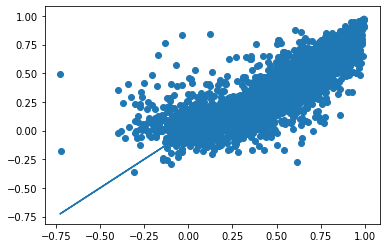

In [7]:
plt.scatter(all_corr_bayes, all_corr_proba)
plt.plot(all_corr_bayes, all_corr_bayes)
plt.show()

In [8]:
np.mean(all_corr_bayes), np.mean(all_corr_proba)

(0.5228485676895513, 0.4239719941990325)

In [9]:
def plot_correlations(attr, correlations_ridge, correlations_proba, n_data=50):
    x = np.array([data.truth[attr] for data in datasets])
    xcor_ridge = spearmanr(x, correlations_ridge).correlation
    xcor_proba = spearmanr(x, correlations_proba).correlation
    x_smooth, y_smooth = smooth_data(x, correlations_ridge, n_data=n_data)
    plt.plot(x_smooth, y_smooth, label="t-learner")
    x_smooth, y_smooth = smooth_data(x, correlations_proba, n_data=n_data)
    plt.plot(x_smooth, y_smooth, label="proba")
    plt.title(f"t-learner: {xcor_ridge:.2f}, proba: {xcor_proba: .2f}")
    plt.legend()
    plt.show()

### Plot correlations as a function of the dataset parameters

Below we show differences between the two algorithms with respect to the properties of the dataset.

First up is the amount of noise added to the feature matrix. Obviously, more noise means worse results. On the other hand, it seems like the t-learner is better at extracting information out of less noisy data.

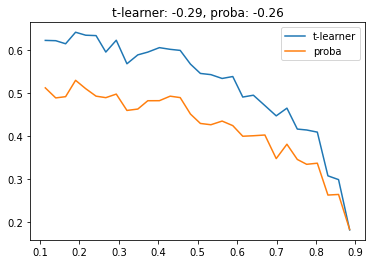

In [10]:
plot_correlations("noise_frac", all_corr_bayes, all_corr_proba, n_data=30)

From the next plot it seems that the number of samples a reasonably strong influence now.

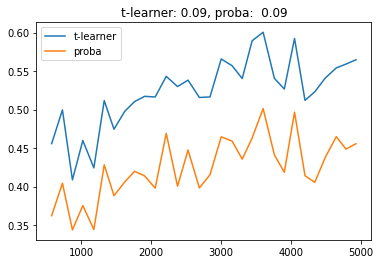

In [11]:
plot_correlations("n_samples", all_corr_bayes, all_corr_proba, n_data=30)

Next up is the `control_precision` parameter that signifies how much the outcome of the untreated/control group depends on the other features, with higher values indicating stronger relations. It looks like the probabilistic method has more trouble with stronger relations for the control group, but the difference is relatively uniform.

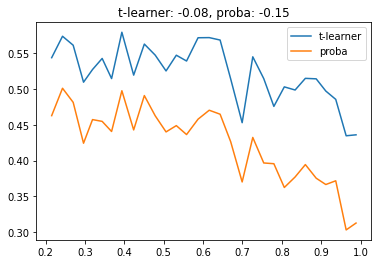

In [12]:
plot_correlations("control_precision", all_corr_bayes, all_corr_proba, n_data=30)

The last parameter to be looked at is `control_unique`. This controls how similar the responses are for the control group and the treatment group. If the parameter is 1, then it means that there is likely to be less correlation between the control and treatment responses. Differences are small, but it seems like the t-learner has a harder time with lower values, while the probabilistic method has a harder time with larger values.

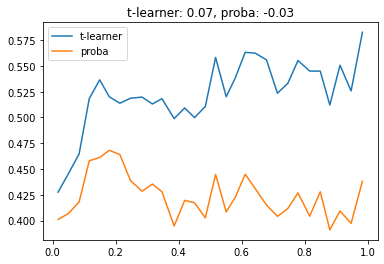

In [13]:
plot_correlations("control_unique", all_corr_bayes, all_corr_proba, n_data=30)

In [14]:
def split_linear(corr, datasets):
    linear_res = [corr[i] for i in range(len(datasets)) if datasets[i].linear == True]
    non_linear_res = [corr[i] for i in range(len(datasets)) if datasets[i].linear == False]
    return linear_res, non_linear_res

In [15]:
print([np.mean(x) for x in split_linear(all_corr_bayes, datasets)])
print([np.mean(x) for x in split_linear(all_corr_proba, datasets)])

[0.7542522025317829, 0.2839196113890358]
[0.656415408787371, 0.18396944417692676]


Above we have split the results in the linear and non-linear datasets for both the probabilistic and the regression model. We find that the regression model is about 15% better for the linear datasets. While both datasets become drastically worse with non-linearity added, the probabilistic method suffers more than the regression model. In this case, the regression model is about 54% better.